In [1]:
using MAT
using Plots
gr()

Plots.GRBackend()

In [2]:
data_dir = "../data/"


"../data/"

In [3]:
stations = matread("$data_dir/stations_loc_all.mat")

Dict{String,Any} with 3 entries:
  "locations"      => [13.9771 730.484 1115.0; 40.6069 757.816 1114.0; … ; 1401…
  "locations_dict" => Dict{String,Any}("SBL"=>[1401.54 2373.27 1084.0],"RIMD"=>…
  "stations"       => Any["NPT" "NPB" … "SBL" "HAT"]

In [4]:
stations["locations"]

13×3 Array{Float64,2}:
    13.9771    730.484  1115.0
    40.6069    757.816  1114.0
   487.291   -1221.49   1117.0
   763.3     -1121.14   1145.0
  -293.11     1343.63   1107.0
  1569.12     -861.434  1146.0
 -1990.18      148.044  1163.0
 -1233.24     1755.9    1240.0
   347.72     2131.37   1091.0
 -1384.87    -1742.64   1133.0
  2220.09      701.412  1059.0
  1401.54     2373.27   1084.0
  2131.02     1920.72   1082.0

In [5]:
dem = matread("$data_dir/Kilauea_DEM_and_lavalakelocation.mat")["DEM"]
vent = matread("$data_dir/VentGeometryData.mat")
#zs_v = vec(vent["zs"])
points_lake = vent["points"][1]

36×3 Array{Float64,2}:
      2.60389e5  2.14728e6  700.0
      2.60391e5  2.14727e6  700.0
      2.60394e5  2.14726e6  700.0
      2.60398e5  2.14726e6  700.0
      2.60403e5  2.14725e6  700.0
      2.6041e5   2.14724e6  700.0
      2.60414e5  2.14723e6  700.0
      2.60421e5  2.14722e6  700.0
      2.60431e5  2.14721e6  700.0
      2.60444e5  2.14721e6  700.0
      2.60456e5  2.14721e6  700.0
      2.60468e5  2.14721e6  700.0
 260479.0        2.14722e6  700.0
      ⋮                     
      2.60488e5  2.14736e6  700.0
      2.60475e5  2.14737e6  700.0
      2.6046e5   2.14738e6  700.0
      2.60444e5  2.14738e6  700.0
      2.60426e5  2.14738e6  700.0
      2.6041e5   2.14738e6  700.0
      2.60395e5  2.14737e6  700.0
      2.60386e5  2.14735e6  700.0
      2.60384e5  2.14733e6  700.0
      2.60385e5  2.14732e6  700.0
      2.60385e5  2.1473e6   700.0
 260386.0        2.14729e6  700.0

In [6]:
x = vec(dem["x"])
y = vec(dem["y"])
Z = dem["Z"]
stations_loc = stations["locations"]
stations_x = stations_loc[:,1]
stations_y = stations_loc[:,2]
stations_z = stations_loc[:,3]
x_lake = 2.604584249773606e+05 # east
y_lake = 2.147270125870880e+06 # north
stations_x .+= x_lake
stations_y .+= y_lake

size(x), size(y), size(Z)

((2511,), (2245,), (2245, 2511))

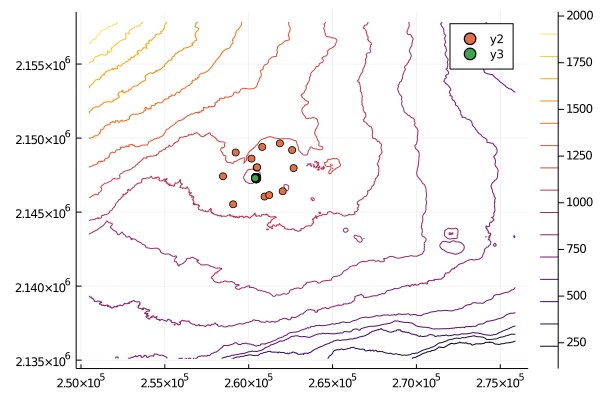

In [7]:
contour(x,y,Z, fill=false)
scatter!(stations_x, stations_y)
scatter!(points_lake[:,1], points_lake[:,2])

In [8]:
using VoronoiDelaunay

In [9]:
# We want to sample place receivers on the lava lake.
# Construct a triangulation of the lava lake, used to lookup whether
# a point is inside
function get_triangulation(points_raw)
    points = Array{Point2D,1}()
    for i=1:size(points_raw,1)
        @views p = points_raw[i,:]
        push!(points, Point2D(p[1], p[2])) # no need to include third dim
    end
    tess = DelaunayTessellation(length(points))
    push!(tess,points)
    tess
end

get_triangulation (generic function with 1 method)

In [10]:
# Delauny only works if coords are between min_coord and max_coord
factor_lake = maximum(points_lake)
normed_lake = points_lake ./ factor_lake
const_lake = min_coord - minimum(normed_lake)
normed_lake .= normed_lake .+ const_lake
@assert min_coord <= minimum(normed_lake) && max_coord >= maximum(normed_lake)
tess = get_triangulation(normed_lake)
tess._total_points_added

36

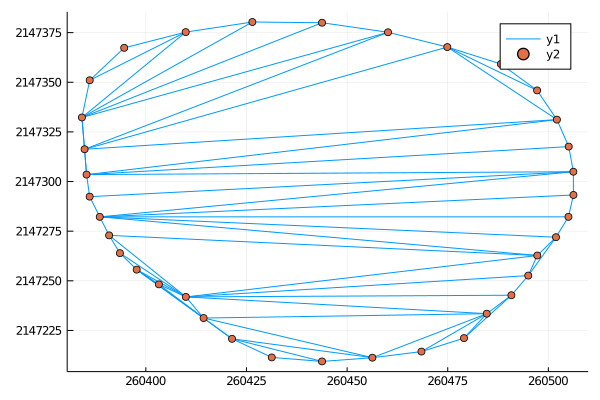

In [11]:
# Plot triangultion as sanity check
x, y = getplotxy(delaunayedges(tess))
plot((x .- const_lake) .* factor_lake, (y .- const_lake) .* factor_lake)
scatter!(points_lake[:,1], points_lake[:,2])

In [15]:
@views lx, ly, lz = points_lake[:,1], points_lake[:,2], points_lake[:,3]
eps = 5 # offset captures bounaries of lake better
small_eps = 1e-7
lx_max, lx_min = maximum(lx) + eps, minimum(lx) + eps
ly_max, ly_min = maximum(ly) + eps, minimum(ly) + eps
lz_max, lz_min = maximum(lz) - small_eps, minimum(lz) - small_eps # Note: no eps here to capture surface correctly!
@assert lz_max == lz_min
h = 10 # [m] Distance between two receivers
lx_range = range(lx_min, lx_max, step=h)
ly_range = range(ly_min, ly_max , step=h)
receivers_lake_x = []
receivers_lake_y = []
receivers_lake_z = []
for x in lx_range
    for y in ly_range
        # We're not sure whether the receivers are actually inside of the lake
        # Hence check if they're in it
        x_normed = x / factor_lake + const_lake
        y_normed = y / factor_lake + const_lake
        @assert min_coord <= x_normed && max_coord >= x_normed
        if !isexternal(locate(tess, Point(x_normed, y_normed)))
            push!(receivers_lake_x, x) 
            push!(receivers_lake_y, y)
            push!(receivers_lake_z, lz_max) # Lake is at 700!
        end
        
    end
end
println("Found $(length(receivers_lake_x)) receivers!")

Found 168 receivers!


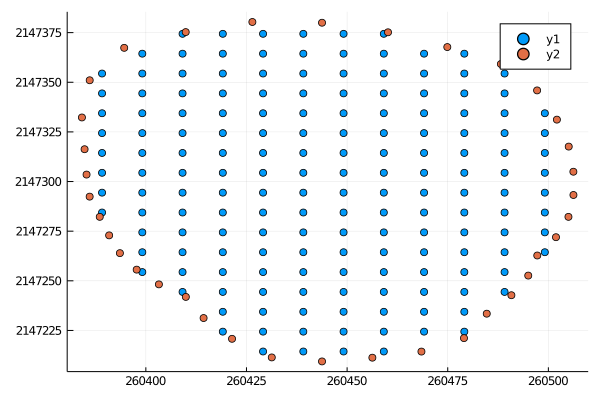

In [16]:
scatter(receivers_lake_x, receivers_lake_y)
scatter!(points_lake[:,1], points_lake[:,2])
#scatter!(stations_x, stations_y)

In [17]:
using Printf
receivers_x = vcat(receivers_lake_x, stations_x)
receivers_y = vcat(receivers_lake_y, stations_y)
receivers_z = vcat(receivers_lake_z, stations_z)
open("../SeisSol-setup/receivers.dat", "w") do io
    for i ∈ eachindex(receivers_x, receivers_y)
        write(io,
            @sprintf "%16.16f %16.16f %16.16f \n" receivers_x[i] receivers_y[i] receivers_z[i])
    end
end